#### This dataset is available publicly at https://www.kaggle.com/c/house-prices-advanced-regression-techniques/
##### The RMSLE obtained in the competition test set was 0.12611 with ElasticNet and 0.15636 with a Keras Neural Network

In [1]:
# Import some basic libraries for analysing the data

import numpy as np
import pandas as pd
import os

In [2]:
# The input file is read and it is splitted into X and Y:

train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data  = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

Only the price of a few houses is beyond 500000


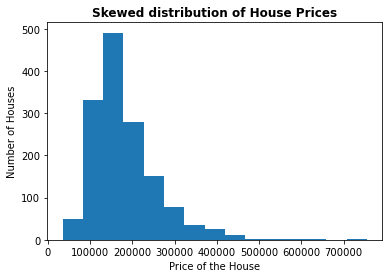

In [3]:
# The house price feature is skewed with many cheap houses and just a few expensive ones:

Y = train_data["SalePrice"]

plt = Y.plot.hist(bins=15)
plt.set_title("Skewed distribution of House Prices", fontweight="bold")
plt.set_xlabel("Price of the House")
plt.set_ylabel("Number of Houses")

print("Only the price of a few houses is beyond 500000")

In [4]:
# For using common linear regression classifiers such as Elastic Net, it is desirable to normalize the price with a log.
# Neural networks can learn more complex functions which can more easily adapt to a skewed Y variable.

X = train_data.drop(["SalePrice","Id"], axis=1)
Y =  np.log1p(Y) # Delete this line if using the keras neural network (it was fine-tuned for the skewed version)
IdTest = test_data.Id # Saved the id for the output file, but we do not need it for predicting their price
test_data = test_data.drop("Id", axis = 1)

print ("The number of examples in the train dataset is", X.shape[0], "and each one has", X.shape[1], "features")
print ("The number of examples in the test  dataset is", test_data.shape[0], "and each one has", test_data.shape[1], "features")

The number of examples in the train dataset is 1460 and each one has 79 features
The number of examples in the test  dataset is 1459 and each one has 79 features


#### The features of the dataset were analysed and the following conclusions were drawn:

In [5]:
# For some categorical columns we just dont have enough data so as the model could learn how each category is related to the price of a house.
# This kind of categorical features when splitted into several binary columns were adding noise to the model given that the number of examples we have is limited

categoricalFeaturesToBeExcluded= ["Exterior1st","Exterior2nd","Condition1","Condition2"]
X         = X.drop        (categoricalFeaturesToBeExcluded, axis =1)
test_data = test_data.drop(categoricalFeaturesToBeExcluded, axis =1)

# There is no point in treating MSSubClass as an INTEGER column, given that a bigger or smaller number doesn't mean more or less value.
#it was converted to categorical instead

X         ["MSSubClass"] = X["MSSubClass"].astype(str)
test_data ["MSSubClass"] = test_data["MSSubClass"].astype(str)

# There are several columns which refer to the quality of some aspect of the house and its value is given as a STRING variable.
# It would be desirable to transform the scale from Excellent to Poor into a numerical scale, such as from 5 to 1:

fromStringToInt = {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,np.nan:0}
qualityColumns = ["ExterQual","ExterCond","BsmtQual","BsmtCond","HeatingQC","KitchenQual","FireplaceQu","GarageQual","GarageCond","PoolQC"]
for column in qualityColumns:
    X[column].replace(fromStringToInt, inplace=True)
    test_data[column].replace(fromStringToInt, inplace=True)

In [6]:
# Some of the columns use a different vocabulary for expressing the quality of a feature.
# Therefore, a specific dictionary is needed to convert each feature from String to INTEGER Quality Numbers:

fromStringToIntLotShape = {"Reg":4,"IR1":3,"IR2":2,"IR3":1,np.nan:0}
X["LotShape"].replace(fromStringToIntLotShape, inplace=True)
test_data["LotShape"].replace(fromStringToIntLotShape, inplace=True)

fromStringToIntUtilities = {"AllPub":4,"NoSewr":3,"NoSeWa":2,"ELO":1,np.nan:0}
X["Utilities"].replace(fromStringToIntUtilities, inplace=True)
test_data["Utilities"].replace(fromStringToIntUtilities, inplace=True)

fromStringToIntLandSlope = {"Gtl":3,"Mod":2,"Sev":1,np.nan:0}
X["LandSlope"].replace(fromStringToIntLandSlope, inplace=True)
test_data["LandSlope"].replace(fromStringToIntLandSlope, inplace=True)

fromStringToIntBsmtFinType = {"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,np.nan:0}
X["BsmtFinType1"].replace(fromStringToIntBsmtFinType, inplace=True)
test_data["BsmtFinType1"].replace(fromStringToIntBsmtFinType, inplace=True)
X["BsmtFinType2"].replace(fromStringToIntBsmtFinType, inplace=True)
test_data["BsmtFinType2"].replace(fromStringToIntBsmtFinType, inplace=True)

fromStringToIntFunctional = {"Typ":8,"Min1":7,"Min2":6,"Mod":5,"Maj1":4,"Maj2":3,"Sev":2,"Sal":1,np.nan:0}
X["Functional"].replace(fromStringToIntFunctional, inplace=True)
test_data["Functional"].replace(fromStringToIntFunctional, inplace=True)

fromStringToIntGarageFinish = {"Fin":3,"RFn":2,"Unf":1,np.nan:0}
X["GarageFinish"].replace(fromStringToIntGarageFinish, inplace=True)
test_data["GarageFinish"].replace(fromStringToIntGarageFinish, inplace=True)

fromStringToIntPavedDrive = {"Y":3,"P":2,"N":1,np.nan:0}
X["PavedDrive"].replace(fromStringToIntPavedDrive, inplace=True)
test_data["PavedDrive"].replace(fromStringToIntPavedDrive, inplace=True)

fromStringToIntFence = {"GdPrv":4,"MnPrv":3,"GdWo":2,"MnWw":1,np.nan:0}
X["Fence"].replace(fromStringToIntFence, inplace=True)
test_data["Fence"].replace(fromStringToIntFence, inplace=True)

In [7]:
print ("The number of examples in the train dataset is", X.shape[0], ". After dropping and modifying features, each example has", X.shape[1], "features")
print ("The number of examples in the test  dataset is", test_data.shape[0], ". After dropping and modifying features, each example has", test_data.shape[1], "features")

The number of examples in the train dataset is 1460 . After dropping and modifying features, each example has 75 features
The number of examples in the test  dataset is 1459 . After dropping and modifying features, each example has 75 features


In [8]:
# Before splitting categorical variables into binary columns, let's get only the numerical columns and check which ones are skewed:
# The skewed features were transformed using a Log and adding a small number to each row so the log of 0 was never computed.
nameOfNumericColumns = X.dtypes[X.dtypes!="object"].index

skewedVariables = X[nameOfNumericColumns].skew()
print ("There are",len([variable for variable in skewedVariables if variable>1]),"skewed variables before transforming")
for index, value in enumerate (skewedVariables):
    if (value > 1):
        X[nameOfNumericColumns[index]]         = np.log (X[nameOfNumericColumns[index]]+0.001)
        test_data[nameOfNumericColumns[index]] = np.log (test_data[nameOfNumericColumns[index]]+0.001)

skewedVariables = X[nameOfNumericColumns].skew()
print ("There are",len([variable for variable in skewedVariables if variable>1]),"skewed variables after  transforming")

There are 22 skewed variables before transforming
There are 10 skewed variables after  transforming


In [9]:
# All the features with a greater percentage than desired of NaNs are dropped since they will not generalise well:

percentageMissingValuesPerColumn = (len(X)-X.count())/len(X)*100
maxPercentageDesired = 0.05 # 5%

falseTrueColumns = percentageMissingValuesPerColumn > maxPercentageDesired
columnIndexesToBeDropped = []

for i in range (X.shape[1]):
    if (falseTrueColumns[i]): # True means that column has more percentage of NaNs than desired
        columnIndexesToBeDropped.append(i)
        
X_clean = X.drop(X.columns[columnIndexesToBeDropped], axis=1)
test_data_clean = test_data.drop(test_data.columns[columnIndexesToBeDropped], axis=1)

In [10]:
# The data is concatenated in order to split categorical columns into binary columns and for calculating the variance within each feature

allData = pd.concat([X_clean, test_data_clean])
allData_clean = pd.get_dummies(allData)

print ("After dropping and splitting, the data contains", allData_clean.shape[1], "features.")

After dropping and splitting, the data contains 164 features.


In [11]:
# Given that the range of values within each feature is different, we have to consider each column's maximum to check if the variance of each feature is enough to be useful for predicting house prices
# All unnecessary features with low variance will result in noise which the model will also try to predict

variancePerColumn  = allData_clean.var( axis=0)
maximumPerColumn   = allData_clean.max( axis=0)

columnsWorthKeeping = []

for i in range (len (variancePerColumn)):
     if ((variancePerColumn[i]/maximumPerColumn[i])> 0.01):
        columnsWorthKeeping.append(i)
        
allData_clean = allData_clean.iloc[:,columnsWorthKeeping]

print ("After removing low-variance columns, the data contains", allData_clean.shape[1], "features.")

After removing low-variance columns, the data contains 118 features.


In [12]:
# The following step was to input missing values in the data. The mean of each feature was calculated:

mean = np.mean (allData_clean) # Contains the mean of each feature

allData_clean = np.array(allData_clean.values) # Converts the dataframe to a numpy array


for i in range (allData_clean.shape[0]):
    for j in range (allData_clean.shape[1]):
        if (np.isnan(allData_clean[i][j])):
            allData_clean[i][j] = mean[j]

# Splitting the agregated data into training and test data again:

X_clean = allData_clean[:1460]
test_data_clean = allData_clean[1460:]

print ("The number of examples in the train dataset is", X_clean.shape[0], ". Each example has", X_clean.shape[1], "features")
print ("The number of examples in the test  dataset is", test_data_clean.shape[0], ". Each example has", test_data_clean.shape[1], "features")


The number of examples in the train dataset is 1460 . Each example has 118 features
The number of examples in the test  dataset is 1459 . Each example has 118 features


In [13]:
# Split the X_clean data into train and validation sets. There are 1460 examples so 1200 / 260 seems reasonable:

random_list = np.random.permutation(1460)
cuttingNumber = 1200

X_clean = np.array(X_clean)
X_train = X_clean [random_list[:cuttingNumber]]
Y_train = Y       [random_list[:cuttingNumber]]
X_val   = X_clean [random_list[cuttingNumber:]]
Y_val   = Y       [random_list[cuttingNumber:]]
test_data_clean = np.array(test_data_clean)

print ("Out of", X_clean.shape[0],"examples,", X_train.shape[0], "houses were included in the training set and", X_val.shape[0],"in the validation set")
print ("The shape of Y_train and Y_val is also correct:",Y_train.shape[0],"/",Y_val.shape[0])

Out of 1460 examples, 1200 houses were included in the training set and 260 in the validation set
The shape of Y_train and Y_val is also correct: 1200 / 260


### Any model needs the distribution of data to be the same in the training, validation and test sets. This was checked using a PCA:

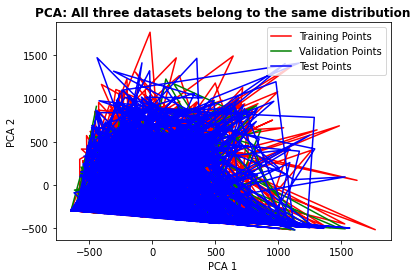

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA (n_components=2)

concat = np.concatenate((X_train,X_val,test_data_clean),axis=0)
pca.fit(concat)

trainPoints = pca.transform(X_train)
valPoints = pca.transform(X_val)
testPoints = pca.transform (test_data_clean)

plt.plot(trainPoints[:,0], trainPoints[:,1], c="red")
plt.plot(valPoints[:,0], valPoints[:,1], c="green")
plt.plot(testPoints[:,0], testPoints[:,1], c="blue")

plt.title ("PCA: All three datasets belong to the same distribution", fontweight="bold")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(["Training Points","Validation Points","Test Points"])
plt.show()

In [15]:
# It is also important to remove outliers in order not to overfit the model on them.
# The tool DBScan was tuned to remove around 12 outliers (~1% of the data)
# The object returned is an array which contains "-1" in the indexes of the outliers.

from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(eps=300, min_samples=3)
clusters = outlier_detection.fit_predict(X_train)

print ("This setup has detected",(sum(clusters == -1)),"outliers.")

X_train_noOutliers = X_train[clusters!=-1]
Y_train_noOutliers = Y_train[clusters!=-1]

print ("The number of examples the model will be trained on is:", len(X_train_noOutliers))

This setup has detected 13 outliers.
The number of examples the model will be trained on is: 1187


### The model that obtained better result was ElasticNet. This model uses both L1 and L2 regularization and their relative importance is stated in the "l1_ratio" variable.
#### Grid Search was used to tune and obtain the best parameters

In [16]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

import warnings #This tool will always throw ConvergenceWarnings unless you leave the model running (and probably overfitting) for a long time
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

elastic = ElasticNet(random_state=1, max_iter=1000)
param = {'l1_ratio' : [0],
             'alpha' : [0.02]} # Parameters to be tuned

elastic = GridSearchCV(elastic, param, cv=5, scoring='neg_mean_squared_error')
elastic.fit(X_train_noOutliers,Y_train_noOutliers)
print('Elastic score:', np.sqrt(elastic.best_score_*-1))

Elastic score: 0.12621027532082357


In [17]:
# The predictions given by this algorithm have to be exponentiated again (remember the house prices were logged at the start!):

predictions = elastic.predict(test_data_clean)
predictions = np.expm1(predictions)
output = pd.DataFrame({'Id':IdTest,'SalePrice':predictions})
output.to_csv("my_submission.csv", index=False)
print ("Your submission was succesfully saved!")

Your submission was succesfully saved!


##### Down belown, the neural network has been commented out. The score obtained in the test set was 0.15646 whereas ElasticNet obtained a smaller RSMLE: 0.12611

In [18]:
"""
import tensorflow as tf
from tensorflow import keras
def rmsle_error(y_true, y_pred): # Custom loss is used for RMSLE
    return tf.math.sqrt(keras.losses.MSLE(y_true, y_pred))
"""

'\nimport tensorflow as tf\nfrom tensorflow import keras\ndef rmsle_error(y_true, y_pred): # Custom loss is used for RMSLE\n    return tf.math.sqrt(keras.losses.MSLE(y_true, y_pred))\n'

In [19]:
"""
# Sometimes the model gets stuck because of a local optima around 12. Other times the gradients exploit and the model returns Nan.
# In both these cases we have to restart the model:

initialLoss = 100
finalLoss = np.nan
restartingCallback = keras.callbacks.EarlyStopping(baseline = 8,patience=20,min_delta=0.0001)
# This callback spots those times when the model gets stuck in the first epoch

while (initialLoss > 8 or (not finalLoss > 0)):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=100, activation = "relu", input_shape = [X_train.shape[1],],kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=75, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=50, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=25, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=15, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))
    model.add(keras.layers.Dense(units=1,  activation = "relu",kernel_initializer=keras.initializers.GlorotNormal))
    model.compile(optimizer = keras.optimizers.Adam(lr=0.0003), loss = rmsle_error)
    history = model.fit (X_train, Y_train, batch_size=16, epochs = 400, callbacks=[restartingCallback], verbose=1, validation_data = (X_val,Y_val))
    initialLoss = history.history["loss"][0]
    finalLoss = history.history["loss"][-1]
    print (model.evaluate(X_val, Y_val))
"""

'\n# Sometimes the model gets stuck because of a local optima around 12. Other times the gradients exploit and the model returns Nan.\n# In both these cases we have to restart the model:\n\ninitialLoss = 100\nfinalLoss = np.nan\nrestartingCallback = keras.callbacks.EarlyStopping(baseline = 8,patience=20,min_delta=0.0001)\n# This callback spots those times when the model gets stuck in the first epoch\n\nwhile (initialLoss > 8 or (not finalLoss > 0)):\n    model = keras.Sequential()\n    model.add(keras.layers.Dense(units=100, activation = "relu", input_shape = [X_train.shape[1],],kernel_initializer=keras.initializers.GlorotNormal()))\n    model.add(keras.layers.Dense(units=75, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))\n    model.add(keras.layers.Dense(units=50, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))\n    model.add(keras.layers.Dense(units=25, activation = "relu",kernel_initializer=keras.initializers.GlorotNormal()))\n 

In [20]:
"""
predictions = np.squeeze(model.predict(test_data_clean), axis=1)
output = pd.DataFrame({'Id':IdTest,'SalePrice':predictions})
output.to_csv("my_submission.csv", index=False)
print ("Your submission was succesfully saved!")
"""

'\npredictions = np.squeeze(model.predict(test_data_clean), axis=1)\noutput = pd.DataFrame({\'Id\':IdTest,\'SalePrice\':predictions})\noutput.to_csv("my_submission.csv", index=False)\nprint ("Your submission was succesfully saved!")\n'